### Парсинг данных и создание датафрейма

In [1]:
# %matplotlib inline
import os

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib notebook

In [2]:
paths = glob.glob(f"build/*ParticleData_t*.csv")

In [3]:
# Вытаскиваем из первого файла названия столбцов
with open(paths[0], 'r') as f:
    lines = []
    while True:
        line = f.readline()
        if line[0] != '#':
            break
        lines.append(line)
    title = lines[1].replace('#title ', '')[:-1]                        # переделать через regex
    sep = chr(int(lines[2].replace('#separator ', '')[:-1]))            # переделать через regex
    vsc_sep = chr(int(lines[3].replace('#vector_separator ', '')[:-1])) # переделать через regex
    columns = [' '.join(i.split(' ')[2:])[:-1] for i in lines[4:]]
    metarows_len = len(lines)

In [4]:
data = pd.DataFrame()
for path in paths:
    item = pd.read_csv(path, skiprows=metarows_len, names=columns)
    data = data.append(item, ignore_index=True)

In [5]:
data

,particle_name,X,Y,Z,vX,vY,vZ,energy
0,e-,18.16210,53.6247,-149.5410,0.059120,0.186642,-0.522422,0.245556
1,e-,-51.79130,150.9340,10.2207,-0.189411,0.569682,0.032910,0.278062
2,e-,-6.27844,144.8380,67.4570,-0.024100,0.538513,0.251722,0.273260
3,e-,128.07700,93.0929,-22.3144,0.447956,0.320987,-0.073941,0.244173
4,e-,-69.58600,128.4620,64.9868,-0.232763,0.446314,0.228853,0.241908
...,...,...,...,...,...,...,...,...
408,e-,-143.63700,59.2914,37.6951,-0.550056,0.237271,0.153943,0.291296
409,e-,-2.39464,127.2390,-96.8117,-0.008607,0.485991,-0.376152,0.288296
410,e-,-9.04842,154.8900,-38.6674,-0.028871,0.571973,-0.145780,0.270256
411,e-,-50.43190,58.2439,-140.1150,-0.189786,0.217010,-0.520542,0.273345


In [6]:
set(data["particle_name"])

{'e-', 'gamma'}

### Создание диаграммы

In [15]:
xyz_e = data[data["particle_name"]=="e-"][["X", "Y", "Z"]]

<IPython.core.display.Javascript object>


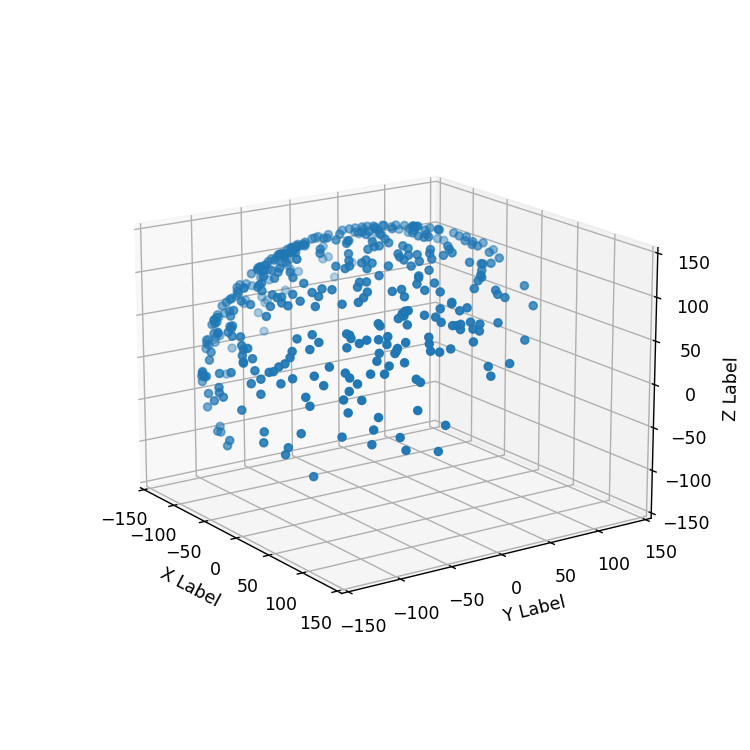

In [16]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_e["X"], xyz_e["Z"],xyz_e["Y"])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.set_zlim(-150, 150)
plt.show()